In [1]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import random
import math
import torch.nn.functional as F
from torch.nn import init

In [2]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes    
        
        self.conv1 = nn.Conv2d(1, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        #do relu here
        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)
        self.relu4 = nn.ReLU(inplace=True)

        self.fc = nn.Linear(2048, 136)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1)) 
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
model = Xception()
# model.load_state_dict(torch.load('/tf/AA002/Final models/Landmark Detection/LMD_xception_v.3.pth',map_location='cuda'))
model = model.cuda()

In [4]:
# X = np.load('/tf/AA002/Data/LandmarkD/300LP/imar_300wlp_2d_extcrop5.npy')/255
# Y = np.load('/tf/AA002/Data/LandmarkD/300LP/label_300wlp_2d_extcrop5.npy')/224
X = np.load('/tf/AA002/Data/LandmarkD/300LP/imar_300wlp_2d_nextcrop.npy')/255
Y = np.load('/tf/AA002/Data/LandmarkD/300LP/label_300wlp_2d_nextcrop.npy')/224

In [5]:
# ind = np.array(random.sample(list(range(X.shape[0])),X.shape[0]))

In [6]:
tsize = int(X.shape[0]*.95)

In [7]:
# X_train = torch.tensor(X[ind][:tsize]).float()
# Y_train = torch.tensor(Y[ind][:tsize]).float()
# X_test = torch.tensor(X[ind][tsize:]).float()
# Y_test = torch.tensor(Y[ind][tsize:]).float()

In [8]:
X_train = torch.tensor(X[:tsize]).float()
Y_train = torch.tensor(Y[:tsize]).float()
X_test = torch.tensor(X[tsize:]).float()
Y_test = torch.tensor(Y[tsize:]).float()

In [9]:
class Dataset(Dataset):
    def __init__(self, X,Y):
        self.dataset = X
        self.label = Y

    def __getitem__(self, i):
        return (self.dataset[i], self.label[i])

    def __len__(self):
        return (self.label.shape[0])

In [10]:
traindata = Dataset(X_train,Y_train)
testdata = Dataset(X_test,Y_test)

In [11]:
### Prameter block
batch_size = 32
learning_rate = 1e-5
max_grad_norm = .5
clipgrad = False
log_interval = 500
wei_dec = 1e-5
model_name = 'LMD_xception_300WLP_gray_nextcrop.pth'

In [12]:
train_dataloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, num_workers=0) #, shuffle=True
test_dataloader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, num_workers=0)

In [13]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay =wei_dec)
loss_fn = nn.MSELoss()
# loss_fn = awingloss(t=.5, w=14, a=2.1,eps=1)

In [14]:
num_epoch = 100

In [15]:
#For learning tracking
trl = []
ttl = []

In [16]:
#training scheme
for i in range(num_epoch):
    train_loss = 0
    test_loss = 0
    model.train()
    #### Training
    for batch_id, (x,y) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        pred = model(x.cuda())
        y  = y.cuda()

        loss = loss_fn(pred,y)
        
        loss.backward()
        if clipgrad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        lossavg = (loss/y.shape[0]).data.cpu().numpy()
        train_loss += lossavg
        
        if batch_id % log_interval == 0:
            print('Epoch: ',i+1,' Batch ID: ',batch_id,' Train Loss: ',train_loss / (batch_id+1))
        trl.append(train_loss / (batch_id+1))
        
    #### Evaluation on Testset
    model.eval()
    for batch_id, (x,y) in enumerate(tqdm(test_dataloader)):
        pred = model(x.cuda())
        y  = y.cuda()

        loss = loss_fn(pred,y)

        lossavg = (loss/y.shape[0]).data.cpu().numpy()
        test_loss += lossavg
        
    print('epoch: ',i+1,' Test Loss: ',test_loss / (batch_id+1))
    if len(ttl) > 0:
        if min(ttl) > (test_loss / (batch_id+1)):
            torch.save(model.state_dict(),model_name)
    else : torch.save(model.state_dict(),model_name)
    ttl.append((test_loss/ (batch_id+1)))
#     scheduler.step()

  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  1  Batch ID:  0  Train Loss:  0.012292901985347271
Epoch:  1  Batch ID:  500  Train Loss:  0.0011574175295537567
Epoch:  1  Batch ID:  1000  Train Loss:  0.0007132755130801892


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  1  Test Loss:  0.00012344181329050722


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  2  Batch ID:  0  Train Loss:  0.0030343153048306704
Epoch:  2  Batch ID:  500  Train Loss:  0.00021032136890665674
Epoch:  2  Batch ID:  1000  Train Loss:  0.00019692500322449164


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  2  Test Loss:  6.80603290675208e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  3  Batch ID:  0  Train Loss:  0.0029871673323214054
Epoch:  3  Batch ID:  500  Train Loss:  0.00016357816204759444
Epoch:  3  Batch ID:  1000  Train Loss:  0.00015594799250258354


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  3  Test Loss:  5.119072599579037e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  4  Batch ID:  0  Train Loss:  0.00295653915964067
Epoch:  4  Batch ID:  500  Train Loss:  0.00013645306918222272
Epoch:  4  Batch ID:  1000  Train Loss:  0.00013030154453614644


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  4  Test Loss:  4.1892300608499984e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  5  Batch ID:  0  Train Loss:  0.002950223395600915
Epoch:  5  Batch ID:  500  Train Loss:  0.00011701081147513393
Epoch:  5  Batch ID:  1000  Train Loss:  0.00011174597212202088


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  5  Test Loss:  3.728892267342114e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  6  Batch ID:  0  Train Loss:  0.00295326579362154
Epoch:  6  Batch ID:  500  Train Loss:  0.0001031606667645306
Epoch:  6  Batch ID:  1000  Train Loss:  9.890629173985129e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  6  Test Loss:  3.411158413655357e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  7  Batch ID:  0  Train Loss:  0.0029421099461615086
Epoch:  7  Batch ID:  500  Train Loss:  9.37478795882514e-05
Epoch:  7  Batch ID:  1000  Train Loss:  9.008123556309688e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  7  Test Loss:  3.1760473090495606e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  8  Batch ID:  0  Train Loss:  0.0029244213365018368
Epoch:  8  Batch ID:  500  Train Loss:  8.689591435497364e-05
Epoch:  8  Batch ID:  1000  Train Loss:  8.370877645387924e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  8  Test Loss:  2.854187805496622e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  9  Batch ID:  0  Train Loss:  0.0029066656716167927
Epoch:  9  Batch ID:  500  Train Loss:  8.122620438879386e-05
Epoch:  9  Batch ID:  1000  Train Loss:  7.82715006588679e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  9  Test Loss:  2.6313645882207008e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  10  Batch ID:  0  Train Loss:  0.002832459518685937
Epoch:  10  Batch ID:  500  Train Loss:  7.502904823567208e-05
Epoch:  10  Batch ID:  1000  Train Loss:  7.190257522913137e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  10  Test Loss:  2.506836602454617e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  11  Batch ID:  0  Train Loss:  0.0027412499766796827
Epoch:  11  Batch ID:  500  Train Loss:  6.994102806562884e-05
Epoch:  11  Batch ID:  1000  Train Loss:  6.616878508648514e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  11  Test Loss:  2.5162967070476346e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  12  Batch ID:  0  Train Loss:  0.0026613231748342514
Epoch:  12  Batch ID:  500  Train Loss:  6.554805638429997e-05
Epoch:  12  Batch ID:  1000  Train Loss:  6.13051394891856e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  12  Test Loss:  2.5431715948798227e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  13  Batch ID:  0  Train Loss:  0.002523193834349513
Epoch:  13  Batch ID:  500  Train Loss:  6.229472291907113e-05
Epoch:  13  Batch ID:  1000  Train Loss:  5.7829126019912094e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  13  Test Loss:  2.4992449683243954e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  14  Batch ID:  0  Train Loss:  0.00237460108473897
Epoch:  14  Batch ID:  500  Train Loss:  6.184674311190681e-05
Epoch:  14  Batch ID:  1000  Train Loss:  5.80204661490099e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  14  Test Loss:  2.3073448755894787e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  15  Batch ID:  0  Train Loss:  0.002495666267350316
Epoch:  15  Batch ID:  500  Train Loss:  6.158886720979586e-05
Epoch:  15  Batch ID:  1000  Train Loss:  5.467639583822437e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  15  Test Loss:  2.248904876675321e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  16  Batch ID:  0  Train Loss:  0.002099517500028014
Epoch:  16  Batch ID:  500  Train Loss:  5.2879231703399e-05
Epoch:  16  Batch ID:  1000  Train Loss:  4.702111551590793e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  16  Test Loss:  2.2505673420406917e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  17  Batch ID:  0  Train Loss:  0.0017367633990943432
Epoch:  17  Batch ID:  500  Train Loss:  4.9484521168924114e-05
Epoch:  17  Batch ID:  1000  Train Loss:  4.397061593226863e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  17  Test Loss:  2.2439960184783557e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  18  Batch ID:  0  Train Loss:  0.001741567044518888
Epoch:  18  Batch ID:  500  Train Loss:  4.473435194245802e-05
Epoch:  18  Batch ID:  1000  Train Loss:  4.034949132720693e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  18  Test Loss:  2.2563428789605192e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  19  Batch ID:  0  Train Loss:  0.0016372655518352985
Epoch:  19  Batch ID:  500  Train Loss:  3.928668034612695e-05
Epoch:  19  Batch ID:  1000  Train Loss:  3.576272974651392e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  19  Test Loss:  2.1691982434883055e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  20  Batch ID:  0  Train Loss:  0.0014530365588143468
Epoch:  20  Batch ID:  500  Train Loss:  3.480362419669652e-05
Epoch:  20  Batch ID:  1000  Train Loss:  3.140331656803275e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  20  Test Loss:  2.147708393446616e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  21  Batch ID:  0  Train Loss:  0.0010378367733210325
Epoch:  21  Batch ID:  500  Train Loss:  2.9541193179467517e-05
Epoch:  21  Batch ID:  1000  Train Loss:  2.7235328038964203e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  21  Test Loss:  2.0971356101047907e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  22  Batch ID:  0  Train Loss:  0.0007526949048042297
Epoch:  22  Batch ID:  500  Train Loss:  2.576461363827468e-05
Epoch:  22  Batch ID:  1000  Train Loss:  2.4507633410481415e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  22  Test Loss:  2.176851371586963e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  23  Batch ID:  0  Train Loss:  0.000800852372776717
Epoch:  23  Batch ID:  500  Train Loss:  2.598799140971546e-05
Epoch:  23  Batch ID:  1000  Train Loss:  2.4604405404409895e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  23  Test Loss:  2.0191557071787734e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  24  Batch ID:  0  Train Loss:  0.0009185236995108426
Epoch:  24  Batch ID:  500  Train Loss:  2.244694615400587e-05
Epoch:  24  Batch ID:  1000  Train Loss:  2.1547788346343022e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  24  Test Loss:  1.986412015260915e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  25  Batch ID:  0  Train Loss:  0.00046874763211235404
Epoch:  25  Batch ID:  500  Train Loss:  1.9729544122722194e-05
Epoch:  25  Batch ID:  1000  Train Loss:  1.9502945404158026e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  25  Test Loss:  2.0048833812325027e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  26  Batch ID:  0  Train Loss:  0.00036911648930981755
Epoch:  26  Batch ID:  500  Train Loss:  1.88890326362144e-05
Epoch:  26  Batch ID:  1000  Train Loss:  1.9211971516074822e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  26  Test Loss:  2.0137724580611877e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  27  Batch ID:  0  Train Loss:  0.0002876723592635244
Epoch:  27  Batch ID:  500  Train Loss:  1.905092418989322e-05
Epoch:  27  Batch ID:  1000  Train Loss:  2.0091508590381013e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  27  Test Loss:  2.16420422475494e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  28  Batch ID:  0  Train Loss:  0.0005174562684260309
Epoch:  28  Batch ID:  500  Train Loss:  2.2144244065496746e-05
Epoch:  28  Batch ID:  1000  Train Loss:  1.9978402126123857e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  28  Test Loss:  2.038703842117684e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  29  Batch ID:  0  Train Loss:  0.00023973771021701396
Epoch:  29  Batch ID:  500  Train Loss:  1.7195599537194132e-05
Epoch:  29  Batch ID:  1000  Train Loss:  1.751773573447975e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  29  Test Loss:  1.939849315325167e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  30  Batch ID:  0  Train Loss:  0.00044688620255328715
Epoch:  30  Batch ID:  500  Train Loss:  1.8384021890898418e-05
Epoch:  30  Batch ID:  1000  Train Loss:  1.8432728766937644e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  30  Test Loss:  1.9522887381147788e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  31  Batch ID:  0  Train Loss:  0.0007311655208468437
Epoch:  31  Batch ID:  500  Train Loss:  2.1002669940909307e-05
Epoch:  31  Batch ID:  1000  Train Loss:  2.166024019747279e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  31  Test Loss:  2.0699691458503366e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  32  Batch ID:  0  Train Loss:  0.0012969280360266566
Epoch:  32  Batch ID:  500  Train Loss:  3.338858737415122e-05
Epoch:  32  Batch ID:  1000  Train Loss:  2.801529045962899e-05


  0%|          | 0/60 [00:00<?, ?it/s]

epoch:  32  Test Loss:  1.9363634373803505e-05


  0%|          | 0/1140 [00:00<?, ?it/s]

Epoch:  33  Batch ID:  0  Train Loss:  0.0006300164968706667


KeyboardInterrupt: 

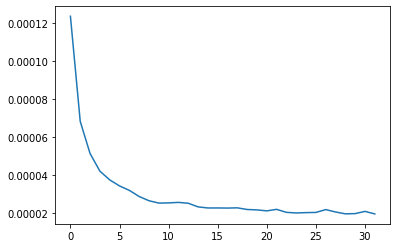

In [17]:
plt.plot(ttl)

In [18]:
model.load_state_dict(torch.load(model_name))
model.eval()
print('')

In [42]:
# torch.save(model.state_dict(),'LMD_Mobilenet_300WLP_croped_v.1.pth')

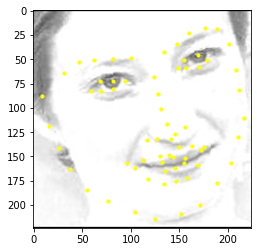

In [52]:
sampled = random.sample(range(X_test.shape[0]),1)[0]
plt.imshow(np.array(torch.moveaxis((255*X_test[sampled]),0,-1)).astype('uint8'),cmap='gray')
pred = model(X_test[sampled][np.newaxis,:,:,:].cuda())
x = pred.detach().cpu().numpy()[0][:68]*224
y = pred.detach().cpu().numpy()[0][68:]*224
ansx = Y_test[sampled][:68]*224
ansy = Y_test[sampled][68:]*224
plt.scatter(x,y,s=10,color='yellow')
# plt.scatter(ansx,ansy,s=10,color='blue')
plt.show()

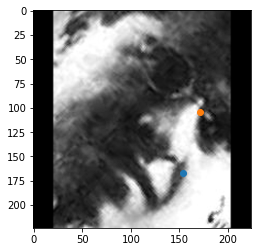

In [226]:
tid=36 # 36:48
plt.imshow(np.array(torch.moveaxis((255*X_test[sampled]),0,-1)).astype('uint8'),cmap='gray')
plt.scatter(x[tid:tid+6].mean(),y[tid:tid+6].mean())
plt.scatter(x[tid+6:tid+12].mean(),y[tid+6:tid+12].mean())

In [227]:
from PIL import Image
import math

In [228]:
def angle(lex,ley,rex,rey):
    lx = lex.mean()
    ly = ley.mean()
    rx = rex.mean()
    ry = rey.mean()
    sign= ((rx-lx)/abs(lx-rx))
    w= abs(rx-lx)
    h = abs(ry-ly)
    angle = sign * ((ry-ly)/abs(ly-ry)) * (math.atan(h/w)* 180 / math.pi)
    if sign < 0:
        angle += 180
    return angle

In [229]:
rex = x[tid:tid+6]
rey = y[tid:tid+6]
lex = x[tid+6:tid+12]
ley = y[tid+6:tid+12]
ang = angle(lex,ley,rex,rey)

In [230]:
im = Image.fromarray(np.array(torch.moveaxis((255*X_test[sampled]),0,-1)).reshape(224,224).astype('uint8'),"L")

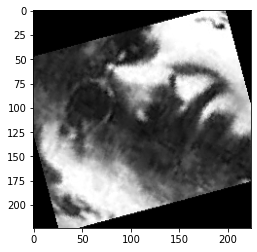

In [231]:
plt.imshow(np.array(im.rotate(angle(lex,ley,rex,rey))),cmap='gray')